# Global temperature anomaly over the last 22 thousand years

This infographic is based on two datasets:
- For the period −20000 up to 1880 (including), the temperature reconstruction from [Osman et al. (2021)](https://www.nature.com/articles/s41586-021-03984-4) is used. (To download the raw data, click the link *"Source Data Fig. 4"* in the *"Source data"* section down on the page.) The baseline is "the preindustrial last millennium average (1000–1850 CE)". For this analysis, we assume the difference from the standard baseline of 1850–1900 is negligible.
- For the period starting 1850, the [NASA GISTEMP v4](https://data.giss.nasa.gov/gistemp/) reconstruction is used. (To download the raw data, use the links in the *"Global-mean monthly, seasonal, and annual means, 1880-present"* subsection under the *"Combined Land-Surface Air and Sea-Surface Water Temperature Anomalies"* heading.) The baseline period is 1951–1980 (approx. 0.19 °C above 1850–1900).

This notebook relies on three libraries:
- `tidyverse` for data wrangling and visualization
- `readxl` for reading Excel files
- `svglite` for exporting the generated chart to SVG


In [ ]:
library(readxl)
library(tidyverse)

theme_set(
  theme_minimal(base_size = 12) +
    theme(
      panel.grid.minor.x = element_blank(),
      panel.grid.minor.y = element_blank(),
      # Inner plot margins: top, right, bottom left.
      plot.margin = unit(c(0, 0, 0, 0), "mm"),
      strip.clip = "off"
    )
)

# The Osman et al. analysis use 1000–1850 as the reference period. Although
# previous analyses indicated a slight cooling in the last millenium (on the
# order of 0.1–0.2 °C), no such cooling appears to be present in the LGMR
# series. Hence, we assume that the offset relative to the standard
# preindustrial baseline is approximately zero.
lgmr_correction <- 0.0
# GISTEMP uses 1951–1980 as the reference period. The recommended correction
# for shifting to the standard preindustrial baseline is adding about 0.19 °C
# (as of January 2025). For details, see the FAQ:
# https://data.giss.nasa.gov/gistemp/faq/#q102a
gistemp_correction <- .19

colour_mean <- "#5c7897"
colour_band <- "#b4bec9"
path_gistemp <- "../data/nasa/gistemp_v4.csv"
path_lgmr <- "../data/osman_et_al_2021/41586_2021_3984_MOESM4_ESM.xlsx"


## Load and prepare data

In this, we read in both datasets, unify column names and reference periods, and join them together. Since there is no overlap in the periods, we can just append the rows.


In [4]:
temp_lgmr <- path_lgmr |>
  read_xlsx(sheet = "4a") |>
  select(BP = 1, Anomaly = 2, AnomalyQ025 = 4, AnomalyQ975 = 5) |>
  # Time is given in BP, before present, where present = 1950 by convention.
  mutate(Year = 1950 - BP, .before = "BP", .keep = "unused") |>
  arrange(Year) |>
  mutate(
    across(starts_with("Anomaly"), ~ .x + lgmr_correction)
  )

temp_gistemp <- path_gistemp |>
  read_csv(skip = 1, na = "***") |>
  select(Year, Anomaly5180 = `J-D`) |>
  filter(!is.na(Anomaly5180)) |>
  # We skip uncertainty bands for GISTEMP, because they're quite small
  # compared to the uncertainties in the LGMR.
  mutate(
    Anomaly = Anomaly5180 + gistemp_correction,
    AnomalyQ025 = NA,
    AnomalyQ975 = NA,
    .keep = "unused"
  ) |>
  arrange(Year)

temp_22k <- bind_rows(temp_lgmr, temp_gistemp) |>
  filter(Year >= -20000)


Temperature anomalies in the five most recent years:


In [6]:
tail(temp_22k, 5)


Year,Anomaly,AnomalyQ025,AnomalyQ975
<dbl>,<dbl>,<dbl>,<dbl>
2020,1.20,NA,NA
2021,1.04,NA,NA
2022,1.08,NA,NA
2023,1.36,NA,NA
2024,1.47,NA,NA


## Chart


Warning message:
“Removed 145 rows containing missing values or values outside the scale range
(`geom_ribbon()`).”


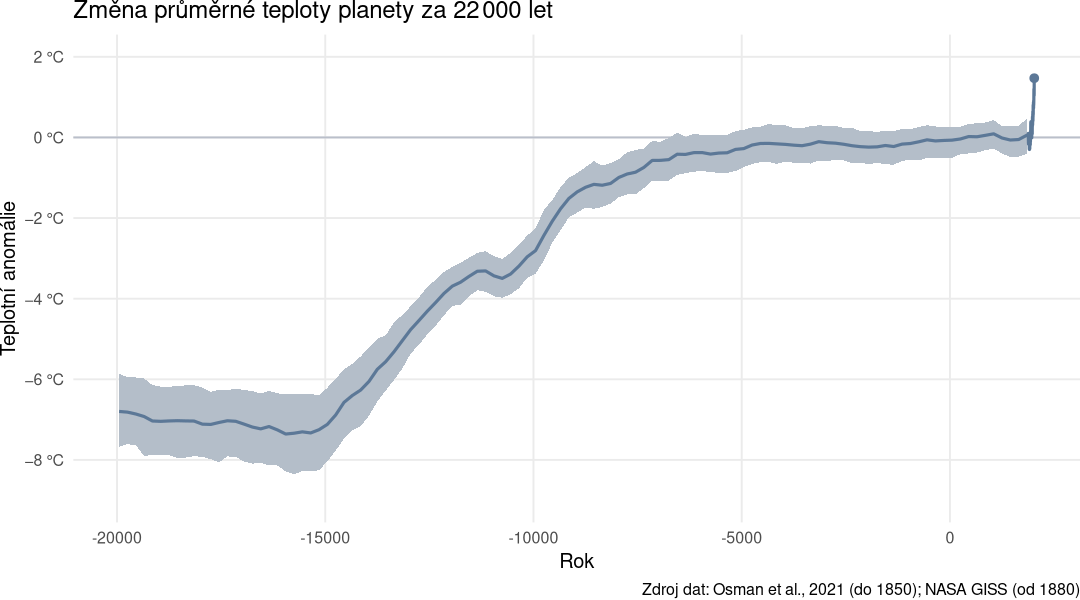

In [9]:
chart_height <- 5
chart_width <- 9
options(repr.plot.height = chart_height, repr.plot.width = chart_width)

p_temps <- ggplot(temp_22k, aes(Year, Anomaly)) +
  geom_hline(yintercept = 0, colour = "#babfca") +
  geom_ribbon(
    aes(ymin = AnomalyQ025, ymax = AnomalyQ975),
    fill = colour_band
  ) +
  geom_line(colour = colour_mean, linewidth = .9) +
  geom_point(
    data = \(df) filter(df, Year == max(Year)),
    colour = colour_mean,
    size = 2
  ) +
  scale_y_continuous(
    "Teplotní anomálie",
    breaks = seq(-10, 2, 2),
    limits = c(-9, 2),
    labels = scales::label_number(suffix = " °C", style_negative = "minus")
  ) +
  coord_cartesian(clip = "off") +
  labs(
    x = "Rok",
    title = "Změna průměrné teploty planety za 22 000 let",
    caption = "Zdroj dat: Osman et al., 2021 (do 1850); NASA GISS (od 1880)"
  )

p_temps


## SVG export


In [ ]:
svglite::svglite(
  "../outputs/global-temperature-22000-years.svg",
  height = chart_height,
  width = chart_width
)
p_temps
dev.off()
